# Predicting Location via Indoor Positioning System 
## Analysis and Modeling in Python 
This script and subsequent notebooks are the Python conversion of the Indoor Location case study from the book, 'Data Science in R' by Nolan and Lang. http://rdatasciencecases.org/code.html <BR>
* Team: Jonathan Tan, Lance Dacy, Reannan Mcdaniel, Shawn Jung 
* Last Update: 5/14/2020 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.spatial import distance
from sklearn.model_selection import KFold
%matplotlib inline 

In [2]:
# Let's load online data 

online_pivot = pd.read_csv('./data/online_pivot.csv')
online_pivot[['pos_x', 'pos_y']] = online_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)

# We will load offline data, and process by different angle ranges
offline = pd.read_csv('./data/offline_processed2.csv')

In [3]:
# Let's define a train data selector, by giving three different angle ranges 
def train_select(train_full_df, angles=[0.0, 90.0, 135.0]):
    train_pivot = train_full_df[train_full_df['orientation'].isin(angles)].reset_index(drop=True)
    train_pivot['pos_xy'] = train_pivot[['pos_x', 'pos_y']].astype(str).agg('-'.join, axis=1)
    train_pivot = pd.pivot_table(train_pivot, values='signal', index='pos_xy', columns='mac', aggfunc=np.mean).reset_index()
    train_pivot[['pos_x', 'pos_y']] = train_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)

    return train_pivot


In [4]:
offline_pivot = train_select(offline, angles=[90.0, 135.0, 180.0])

In [5]:
test0 = online_pivot.iloc[0,1:8]
train0 = offline_pivot.iloc[0,1:8]

In [6]:
# the Euclidean distance of first records of each data frame can be calcualted like this. 
np.sqrt(np.sum(np.square((np.array(test0) - np.array(train0)))))
# But we will use the scipy library to compare Euclidean and Manhattan distance methods. 

10.412954827804205

In [7]:
distance.euclidean(test0, train0) 
distance.cityblock(test0, train0)

19.368059828510994

In [8]:
# The function returns top k nearest neighbors  
def find_NN(test_array, train_df, k=1, distance_type=distance.cityblock):
    dist = []
    for i in range(train_df.shape[0]):
        #d = np.sqrt(np.sum(np.square((np.array(test_array) - np.array(train_df)[i]))))
        d = distance_type(test_array, np.array(train_df)[i])
        dist.append(d)
    
    dist_result = np.array(dist)
    
    # return the indices of top n lowest values

    return dist_result.argsort()[0:k][::-1]


In [9]:
# The function calculates weighted or simple averaged predicted location, and compare to the actual location. And then return the gap as error 
def error_calc(original_index, predict_index, weighted_mean=True, distance_type=distance.cityblock):
    original_xy = online_pivot.iloc[original_index][['pos_x', 'pos_y']]
    dist = []
    pred_xy = np.zeros([len(predict_index),2])
    for i,p in enumerate(predict_index):
        xy = offline_pivot.iloc[p][['pos_x', 'pos_y']]
        dist.append(1/distance_type(original_xy, xy)) #weighted sum by 1/dist
        pred_xy[i] = xy
    # in case we use weighted mean, 
    if weighted_mean:
        avg_pred_x = np.average(pred_xy[:,0], weights=dist)
        avg_pred_y = np.average(pred_xy[:,1], weights=dist)
    else:
        avg_pred_x = np.average(pred_xy[:,0])
        avg_pred_y = np.average(pred_xy[:,1])

    error = distance_type(original_xy, (avg_pred_x, avg_pred_y))
    return(error)


In [13]:
# This function calculated the mean errors per combination of datasets, k(number of neighbors), distance type and averaging type
def location_scoring(test_df, train_df, k=1, distance_type=distance.cityblock, weighted_mean=True):
    errors = []
    for i in range(test_df.shape[0]):
        predicted_nn = find_NN(test_df.iloc[i], train_df, k, distance_type)
        error = error_calc(i, predicted_nn, weighted_mean, distance_type)
        errors.append(error)
    
    return np.mean(errors)


In [14]:
# Sanity test before running Grid Search!
score = location_scoring(online_pivot.iloc[:,1:8], offline_pivot.iloc[:,1:8], k=1, distance_type=distance.cityblock, weighted_mean=True)
print(score)

2.8374999999999995


### Case 1-2
Assuming we cannot use the ONLINE data, we found the best fit by using cross-validation method

In [15]:
all_angles = np.round(np.linspace(0,405,10),1)
angles=[]
for i in range(len(all_angles)-2):
    angle = all_angles[i:i+3]
    angle = np.where(angle >= 360, angle-360, angle)
    angles.append(angle)

In [16]:
offline_pivot2 = train_select(offline, angles=all_angles[0:3])

In [17]:
# define kfold splits over offline data. We adopt 10 CV splits 
#from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42)


We will make grid-search of hyper parameters with Cross Validation of 10 split on train data. k from 1 to 10, weighted/simple means, and 8 different angle variations will be applied to find the best parameter

In [18]:
k_space = [1,2,3,4,5,6,7,8,9,10]
mean_errors = []
weighted_means = [True, False]

for angle in angles:
    # select offline data with angle ranges, and remove the MAC address C0. 
    offline_df = train_select(offline, angles=angle)
    offline_df = offline_df.iloc[:,1:8].drop(['00:0f:a3:39:e1:c0'], axis=1)
    
    # apply cv split 
    kf.get_n_splits(offline_df)
    for mean_method in weighted_means:
        for k in k_space:
            scores = []
            for train_index, test_index in kf.split(offline_df):
                scores.append(location_scoring(offline_df.iloc[test_index], offline_df.iloc[train_index], k=k, weighted_mean=mean_method))

            mean_error = np.mean(scores)
            mean_errors.append(mean_error)
            #print(f'weighted_mean={mean_method}, k = {k} , mean error = {mean_error:.4f}')



In [19]:
len(mean_errors)

160

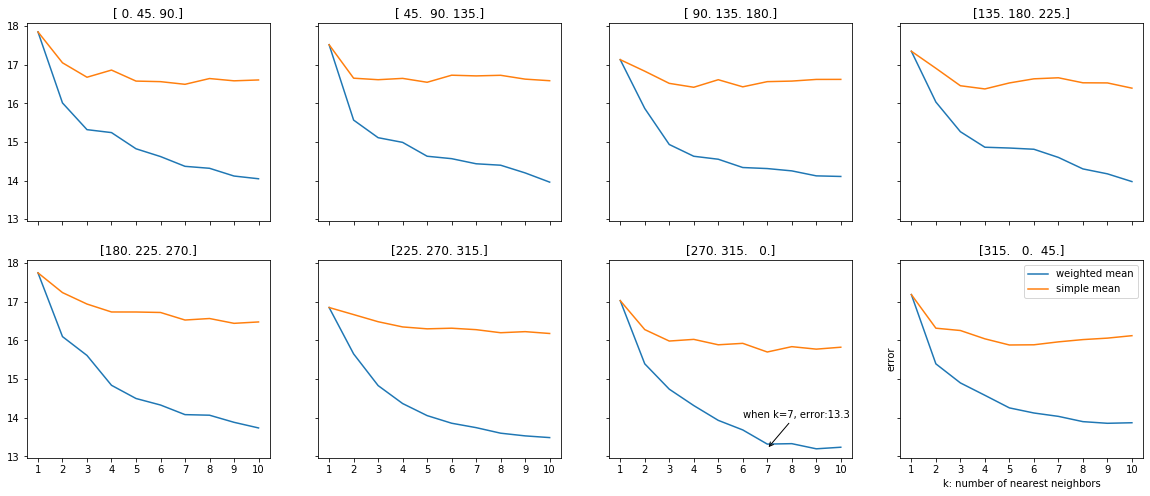

In [30]:
# It appears that we get good 'elbow' value at angles [270, 315, 0] and k=7

fig, axs = plt.subplots(2,4, sharex=True, sharey=True, figsize=(20,8))

for k,v in enumerate(np.linspace(0,140,8, dtype=int)):
    
    axs.flatten()[k].plot(k_space, mean_errors[v:v+10], label='weighted mean')
    axs.flatten()[k].plot(k_space, mean_errors[v+10:v+20], label='simple mean')
    axs.flatten()[k].set_title(str(angles[k]))
    

plt.xticks(k_space)
axs.flatten()[6].annotate('when k=7, error:' + str(np.round(mean_errors[126],1)), xy=(7,13.2), xytext=(6,14), arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
plt.xlabel('k: number of nearest neighbors')
plt.ylabel('error')
plt.legend()
plt.show()

In [31]:
# So let's apply the angle to select the final train data set
offline_pivot = train_select(offline, angles=[270., 315., 0.])

In [32]:
# Let's define 6 MAC addresses, by choosing the one end with 'CD'. 
offline_cd = offline_pivot.iloc[:,1:8].drop(['00:0f:a3:39:e1:c0'], axis=1)
online_cd = online_pivot.iloc[:,1:8].drop(['00:0f:a3:39:e1:c0'], axis=1)

# These are data sets when choosing 'C0'
offline_c0 = offline_pivot.iloc[:,1:8].drop(['00:0f:a3:39:dd:cd'], axis=1)
online_c0 = online_pivot.iloc[:,1:8].drop(['00:0f:a3:39:dd:cd'], axis=1)

# Datasets when we take all 7 MAC addresses
offline_all = offline_pivot.iloc[:,1:8]
online_all = online_pivot.iloc[:,1:8]


Case 1-3 and 1-4 <BR>
Let's compare which one gives better performance. From our analysis, the error was the lowest when we take all 7 MAC address groups

In [37]:
scores_c0 = location_scoring(online_c0, offline_c0, k=7, weighted_mean=True)
scores_cd = location_scoring(online_cd, offline_cd, k=7, weighted_mean=True)
scores_all = location_scoring(online_all, offline_all, k=7, weighted_mean=True)

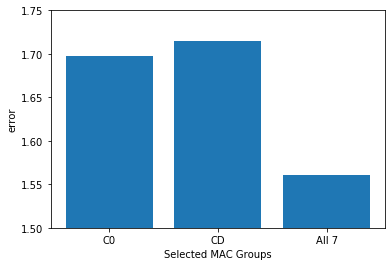

In [38]:
plt.bar(['C0', 'CD', 'All 7'], [scores_c0, scores_cd, scores_all])
plt.ylim([1.5, 1.75])
plt.xlabel('Selected MAC Groups')
plt.ylabel('error')
plt.show()

In [40]:
print(scores_all)
# when choosing angle 90 135 180, and simple means with k1, we got 2.5575 

1.5611929801663664
